In [77]:
library(tidyverse)
library(patchwork)
library(stargazer)
library(scales)
library(broom)


Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor




`summarise()` has grouped output by 'School'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'School'. You can override using the `.groups` argument.



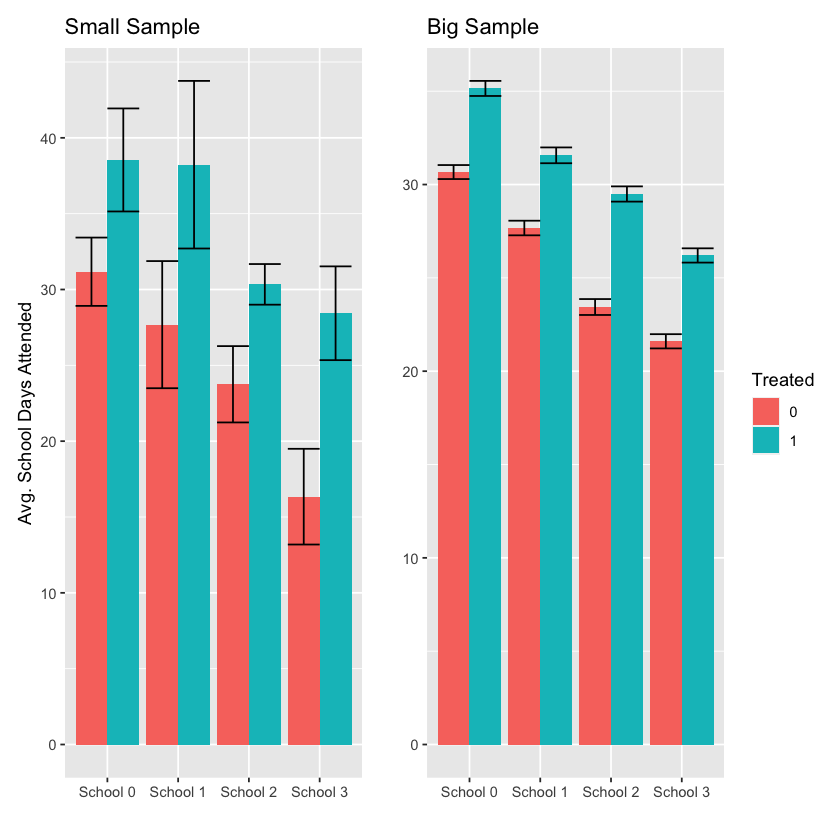

In [105]:
data_gen_func <- function(effect_size,sample_size) {
  data <- tibble(
      # 4 Different schools
      School = sample(0:3,sample_size,replace=TRUE),
      # W = treatment indicator
      W = sample(0:1,sample_size,replace=TRUE)) %>%
    mutate(
      # Avg days attended of 30, they get an effect size boost if they are
      Days_Attended = 30 + effect_size*W  -3*School + rnorm(sample_size, mean = 0, sd = 10),
      School = paste("School",School) %>% as.factor(),
      W = as.factor(W)) %>% 
    return()
}
# EXAMPLE RUN
small_n <- data_gen_func(5,50) %>%
  custom_chart() + 
  labs(title="Small Sample",y="Avg. School Days Attended",x="",fill="Treated")
big_n <- data_gen_func(5,5000) %>% 
  custom_chart()  + 
  labs(title="Big Sample",y="",x="",fill="Treated")

small_n + big_n + plot_layout(guides = "collect")

In [38]:
custom_chart <- function(data){
    data  %>% 
        group_by(School,W) %>% 
        summarize(
            n = n(),
            m=mean(Days_Attended),
            se = sd(Days_Attended)/sqrt(n)) %>% 
        ggplot(aes(School,m,fill=W)) +
        geom_col(position = position_dodge(.9)) +
        geom_errorbar(aes(ymin=m-se,ymax=m+se),position = position_dodge(.9)) %>% 
        return()
    }

In [106]:
analysis_formula <- 'Days_Attended ~ W + School'
estimator_func <-  function(data) lm(as.formula(analysis_formula), data = data)
# EXAMPLE RUN
small_n <- data_gen_func(5,50) %>%
    estimator_func()
big_n <- data_gen_func(5,5000) %>% 
    estimator_func()
stargazer(small_n,big_n,align=TRUE,type="text")



                                  Dependent variable:              
                    -----------------------------------------------
                                   analysis_formula                
                             (1)                     (2)           
-------------------------------------------------------------------
W1                         7.176**                4.967***         
                           (2.772)                 (0.284)         
                                                                   
SchoolSchool 1             -3.921                 -3.864***        
                           (3.668)                 (0.400)         
                                                                   
SchoolSchool 2             -0.305                 -6.667***        
                           (4.212)                 (0.402)         
                                                                   
SchoolSchool 3           -10.800***            

In [107]:
alpha <- 0.05
discriminator_func <- function(model) tidy(model)$p.value[2] <= alpha
# EXAMPLE RUN
small_n <- data_gen_func(5,50) %>%
    estimator_func() %>% 
    discriminator_func()
big_n <- data_gen_func(5,5000) %>% 
    estimator_func() %>% 
    discriminator_func()
paste("Able to detect effect with small sample size?",small_n)
paste("Able to detect effect with large sample size?",big_n)

[1] "Able to detect effect with small sample size? FALSE"

[1] "Able to detect effect with large sample size? TRUE"

In [108]:
calc_power <- function(data_generator,estimator,discriminator,num_sims=500) {
  sig_results <- c()
  for (i in 1:num_sims) {
    # Have to re-create the data EVERY TIME or it will just be the same data over and over
    mock_data <- data_generator()
    # Run the analysis
    model <- estimator(mock_data)
    # Answer your original question (does the treatment have an effect?)
    sig_results[i] <- discriminator(model)
  }
  # Power = proportion of the time you find a statistically significant result
  sig_results %>%
    mean() %>%
    return()
}
# EXAMPLE RUNS
# These are functions that, when called, return the result of the data generator with those parameters
small_n_generator <- function() data_gen_func(5,50)
big_n_generator <-  function() data_gen_func(5,5000)
small_n_power <- calc_power(
    small_n_generator,
    estimator_func,
    discriminator_func) * 100 %>% round(2)
big_n_power <- calc_power(
    big_n_generator,
    estimator_func,
    discriminator_func) * 100 %>% round(2)
paste0("Able to correctly detect effect with small sample size ",small_n_power,"% of the time.")
paste0("Able to correctly detect effect with large sample size ",big_n_power,"% of the time.")

[1] "Able to correctly detect effect with small sample size 40.6% of the time."

[1] "Able to correctly detect effect with large sample size 100% of the time."

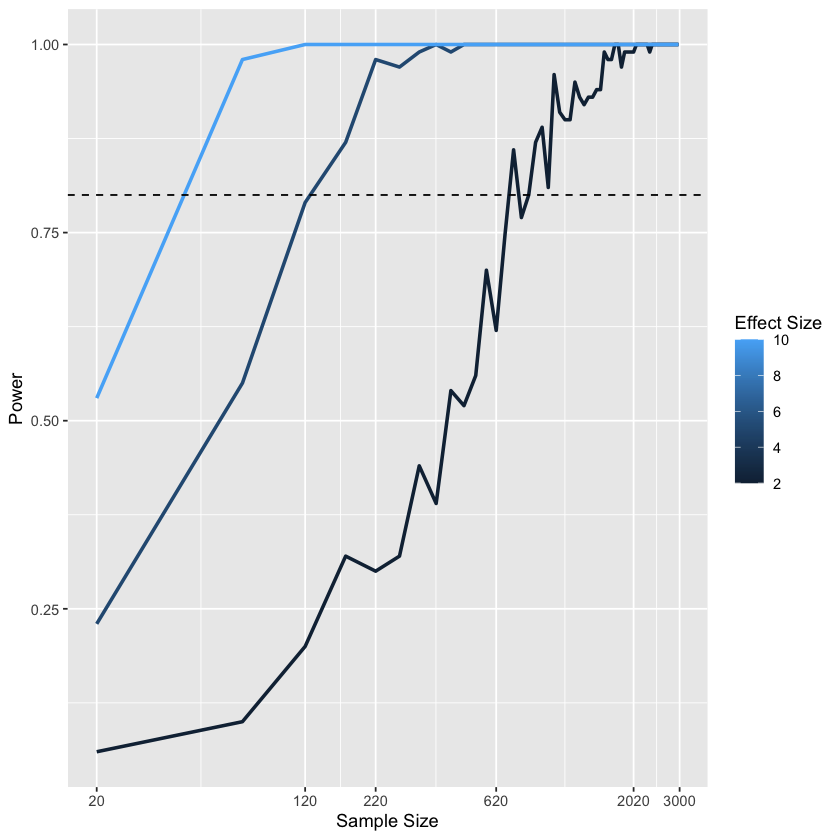

In [98]:
# STUDY DESIGN 
effect_sizes <- c(2,5,10)
sample_sizes <- seq(20, 3000, by = 50)

# Create a dataframe with each effect size (es) and sample size (ss) pair
params <- expand.grid(list(es=effect_sizes,ss=sample_sizes))

# Create parameterized data generators for each effect/sample size pair
create_generator <- function(es,ss) function() data_gen_func(es,ss)
data_generators <- mapply(create_generator,
    params$es,
    params$ss)

# SIMULATION CONSTANTS
power_thresh <- 0.80
num_sims_p_step <- 100
    
power_res <- mapply(
    calc_power,
    data_generators,
    MoreArgs=list(
        estimator = estimator_func,
        discriminator = discriminator_func,
        num_sims = num_sims_p_step)
    )
results <- params  %>% mutate(power = power_res)

ggplot(results,
     aes(x = ss, y = power,group=es,color=es)) +
     geom_line(size=1) +
     # add a horizontal line at 90%
     geom_hline(aes(yintercept = power_thresh), linetype = 'dashed') + 
     scale_x_continuous(trans = log_trans(),breaks=c(20,120,220,620,2020,3000)) +
     labs(x = 'Sample Size', y = 'Power',color='Effect Size')
